# 【名畫變變變 風格遷移】

#### 【組員名單】
* 資管四 105306076 許雲輔
* 資管四 105306067 林承叡
* 資管四 105306005 孫和湉
* 廣告四 105405132 宋靜

#### 【問題與動機】
很多App裡都有把照片轉換成世界級名畫的酷功能。這是怎麼做到的呢？我們該怎麼實作出屬於自己的風格遷移應用？

#### 【主題】
簡單來說，我們要做的事情就是「將某一張圖片 (風格圖) 的風格，套進另一張圖片 (原圖) 中」。

我們將利用著名神經網路「VGG19」的威力，將一張影像的「風格」和「內容」分離開來，進而將風格套到我們的目標圖像。

# Part I - Model 
我們閱讀了VGG19 及Keras Application的相關文檔，藉此了解神經網路VGG19的架構。

接著利用老師上課介紹到的CNN建構方式將其架構出來，最後再載入官方的weight數據。(沒有夠力的硬體設備自己訓練)。

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Input
from keras.layers import Conv2D, MaxPooling2D, InputLayer
from keras.optimizers import SGD

def generateVGG19(input_tensor):
    model = Sequential()
    
    model.add(InputLayer(input_tensor = input_tensor))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))
    
    weights_path = 'vgg19_weights_notop.h5'
    model.load_weights(weights_path, by_name=True)

    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy')

    return model


# Part II - Functions

在進行風格遷移時，我們不只需要一個強大的神經網路來提取圖像的特徵，還需要能夠將風格套進目標圖像的函式。
我們希望成品在內容上盡量和「原圖」相近、在風格上則盡量與「風格圖」相近，所以大概會需要以下幾種函式：

* 損失函數一 “內容損失”（content loss），代表合成的圖像的特徵與基準圖像的特徵之間的L2距離，確保生成的圖像內容和基準圖像保持一致。
* 損失函數二 “風格損失”（style loss），代表合成圖像的特徵與風格圖像的特徵之間的Gram矩陣之間的差異，確保生成圖像的風格和風格圖像保持一致。
* 損失函數三 “差異損失”（variation loss），代表合成的圖像局部特徵之間的差異，確保生成的圖像局部特徵的一致性，整體看上去自然不突兀。

#### 【套件說明】

* **vgg19**：這裡import vgg19 套件是為了直接使用其中的 preprocess_input 函式。
* **fmin_l_bfgs_b**：這是一個 scipy 提供的 L-BFGS優化器。
* **imsave**：scipy.misc 中的 imsave 可以把數組的型式的資料 (如numpy array) 快速存成圖片。
* **PIL**: Python Image Library 裡面有一些好用的影像處理函式，如 ImageEnhance (影像強化)。
* **time**：為了計算風格遷移每次迭代所耗費的時間。

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import vgg19
from keras import backend as K
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from PIL import Image, ImageEnhance
import time
import numpy as np

# 圖片路徑設置、圖片大小、總迭代次數 等等...
base_image_path = 'targets/rooftop.jpg'
style_reference_image_path = 'styles/starry night.jpg'
results_path = 'results/'
iterations = 50
pictrue_size = 744

source_image = Image.open(base_image_path)
source_image= source_image.resize((pictrue_size, pictrue_size))
width, height = pictrue_size, pictrue_size

def save_img(fname, image, image_enhance=True):  # 圖像增強
    image = Image.fromarray(image)
    if image_enhance:
        # 亮度增強
        enh_bri = ImageEnhance.Brightness(image)
        brightness = 1.2
        image = enh_bri.enhance(brightness)
        # 彩度增強
        enh_col = ImageEnhance.Color(image)
        color = 1.2
        image = enh_col.enhance(color)
        # 銳度增強
        enh_sha = ImageEnhance.Sharpness(image)
        sharpness = 1.2
        image = enh_sha.enhance(sharpness)
    imsave(fname, image)
    return

def preprocess_image(image):
    """
    預處理圖片，包括變形到(1，width, height)形狀，數據壓到0-1之間
    """
    image = image.resize((width, height))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = vgg19.preprocess_input(image)
    return image

def deprocess_image(x):
    """
    將0-1之間的數值變回圖片的形式
    """
    x = x.reshape((width, height, 3))
    # 將 preprocess_input 的處理調整回來
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')  # 防止超出255範圍
    return x

# Gram 矩陣
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# 風格損失
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    S_C = S-C
    channels = 3
    size = height * width
    return K.sum(K.square(S_C)) / (4. * (channels ** 2) * (size ** 2))

# 輸入x，輸出對應於 x 的梯度和 loss
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, height, width))
    else:
        x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])  # 輸入x，得到輸出
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# 內容損失
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# 差異損失
def total_variation_loss(x,img_nrows=width, img_ncols=height):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


# 打包成 Evaluator 方便運行及計算
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [ ]:
# 把原圖，風格圖片，結果圖片處理成一個 (3, width, height, 3)的矩陣
base_image = K.variable(preprocess_image(source_image))
style_reference_image = K.variable(preprocess_image(load_img(style_reference_image_path)))
combination_image = K.placeholder((1, width, height, 3))
# 組合以上3張圖片，當成一個 keras輸入向量
input_tensor = K.concatenate([base_image, style_reference_image, combination_image], axis=0)

model = generateVGG19(input_tensor=input_tensor)
print("Model loaded.")
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

loss = K.variable(0.)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
content_weight = 0.08
loss += content_weight * content_loss(base_image_features,
                                      combination_features)
feature_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
feature_layers_w = [0.1,0.1,0.4,0.3,0.1]

for i in range(len(feature_layers)):
    # 每一層的權重以及數據
    layer_name, w = feature_layers[i], feature_layers_w[i]
    layer_features = outputs_dict[layer_name]  # 該層的特徵

    style_reference_features = layer_features[1, :, :, :]  # 參考圖像在VGG網絡中第i層的特徵
    combination_features = layer_features[2, :, :, :]     # 結果圖像在VGG網絡中第i層的特徵

    loss += w * style_loss(style_reference_features, combination_features)  # 目標風格圖像的特徵和結果圖像特徵之間的差異作爲loss

loss += total_variation_loss(combination_image)


# 求得梯度，輸入combination_image，對loss求梯度, 每輪迭代中combination_image會根據梯度方向做調整
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

evaluator = Evaluator()
x = preprocess_image(source_image)
img = deprocess_image(x.copy())
fname = results_path + '原始圖片.png'
save_img(fname, img)

# 開始迭代
for i in range(iterations):
    start_time = time.time()
    print('iteration', i,end="   ")
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20, epsilon=1e-7)
    print('目前loss:', min_val,end="  ")
    img = deprocess_image(x.copy())

    fname = 'result_%d.png' % i
    end_time = time.time()
    print('耗時%.2f s' % (end_time - start_time))

    if i%5 == 0 or i == iterations-1:
        save_img(results_path + fname, img, image_enhance=True)
        print('文件保存爲', fname)

interactive(children=(Dropdown(description='n', options=('rooftops',), value='rooftops'), Output()), _dom_clas…

<function __main__.showTarget(n)>

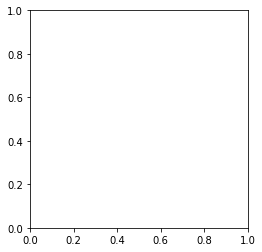

In [4]:
from ipywidgets import interact
import matplotlib.pyplot as plt

def showTarget(n):
    plt.imshow('targets' + n)

interact(showTarget, n=['rooftops'])